In [2]:
import numpy as np
import scipy as sp
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
from time import time as timer
import Branching_Process as bp
import pandas as pd
from tqdm import tqdm
import importlib
import seaborn as sns

sns.set_palette('Set2')
cmap = sns.color_palette('Set2')

In [3]:
importlib.reload(bp)


<module 'Branching_Process' from '/Users/jacobcurran-sebastian/pgf_disc/Branching_Process.py'>

In [4]:
Tmax = 200
nsteps = 2*Tmax +1 
time = np.linspace(0, Tmax, num=nsteps)
time_step = time[1] - time[0]
beta_test = 2/7
gamma_test = 1/7
omega = beta_test + gamma_test
growth_rate = beta_test - gamma_test
R_eff = 3
t_lockdown = 30


a = 6
b = 0.833
# Define distributions for the lifetime, infectivity profile and population-level transmission rate
# For Crump-Mode-Jagers Process

def lifetime(t, tau):
    return sp.stats.gamma.cdf(t, a = a, scale = b) # sp.stats.expon.cdf(t, scale = 1/gamma_test)

def lifetime_pdf(t, tau):
    return sp.stats.gamma.pdf(t, a = a, scale = b) # sp.stats.expon.pdf(t, scale = 1/gamma_test)

def infectiousness(t):
    return sp.stats.gamma.cdf(t, a = a, scale = b)

def infectiousness_pdf(t):
    return sp.stats.gamma.pdf(t, a = a, scale = b)

def Rt(t, R=R_eff):
    return R

def lifetime_exp(t, tau):
    return sp.stats.expon.cdf(t, scale = 1/omega)

def infectiousness_const(t, const = 1):
    return const * np.ones_like(t)

def R_lockdown(t, R1 = R_eff, R2 = 1, t_lockdown = 30):
    return R1 * (t<=t_lockdown)  + R2 * (1-(t <= t_lockdown))

def R_constant(t, R=1):
    return 1    

# Define individual offspring distribution

def logarithmic_offspring(z, phi = 0.1):
    return - phi * (np.log(phi + 1 - z) - np.log(phi))

def poisson_offspring(z, lamb = 1):
    return lamb*(z-1)

def BH_offspring(z):
    return (beta_test * z**2 + gamma_test)/omega

cmj_test = bp.cmj(poisson_offspring, time=time)
cmj_test.set_lifetime_distribution(lifetime)
cmj_test.set_infectiousness_profile(infectiousness)
cmj_test.set_transmission_rate(Rt)
#cmj_test.set_cutoff(80)


#cmj_lockdown = bp.cmj(poisson_offspring, time=time)
#cmj_lockdown.set_lifetime_distribution(lifetime)
#cmj_lockdown.set_infectiousness_profile(infectiousness)
#cmj_lockdown.set_transmission_rate(Rt)

#cmj_ci = bp.cmj(poisson_offspring, time=time)
#cmj_ci.set_lifetime_distribution(lifetime)
#cmj_ci.set_infectiousness_profile(infectiousness)
#cmj_ci.set_transmission_rate(Rt)






def immigration(tau, eta = 0.1):
    return eta*np.exp(-eta*tau)

def intensity_measure(t):
    return R_eff * infectiousness_pdf(t) * (1-lifetime(t, 0)) #* (1-lifetime(t, 0))

lifespan_average = np.linspace(0, a/b)

R0_true = sp.integrate.quad(intensity_measure, 0, 100)[0]

print('R0 is: ' + str(R0_true))

R0 is: 1.5000000000000002


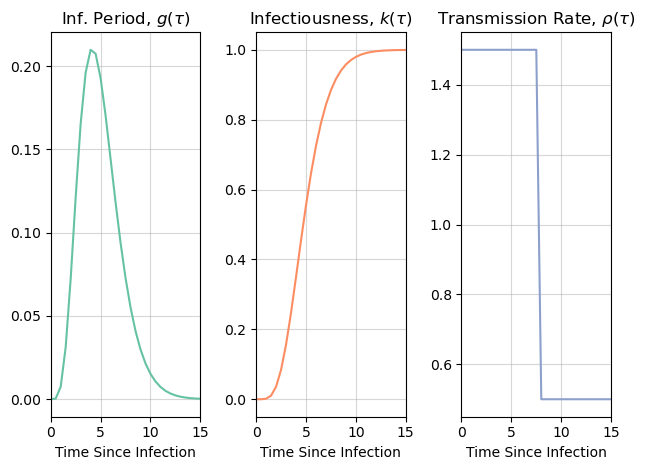

In [5]:
fig, axs = plt.subplots(1, 3)
axs[0].grid(alpha = 0.5)
axs[0].plot(time, lifetime_pdf(time, 0), color = cmap[0])
axs[0].set_xlim([0, 15])
axs[0].set_xlabel('Time Since Infection')
axs[0].set_title('Inf. Period, ' + r'$g(\tau)$')

axs[1].grid(alpha = 0.5)
axs[1].plot(time, infectiousness(time), color = cmap[1])
axs[1].set_xlim([0, 15])
axs[1].set_xlabel('Time Since Infection')
axs[1].set_title('Infectiousness, ' + r'$k(\tau)$')

axs[2].grid(alpha = 0.5)
axs[2].plot(time, R_lockdown(time, 1.5, 0.5, 7.5), color = cmap[2])
axs[2].set_xlim([0, 15])
axs[2].set_xlabel('Time Since Infection')
axs[2].set_title('Transmission Rate, ' + r'$\rho(\tau)$')

fig.tight_layout()
#plt.savefig('/Users/jacobcurran-sebastian/Documents/CMJ_distributions.png')

In [6]:
# How many cases to run pgf until? Can be expensive for large numbers of cases!
max_pgf = 5000

n_cores = 6
characteristic = 'prev'

# Calculate pmf - parallelise for faster results 
start = timer()
if characteristic == 'prev':
    #pmf_test = bp.pmfft(cmj_test.pgf_vec, 
    #                    max_pgf, 
    #                    count = 'prev',
    #                    parallel = True,
    #                    n_cores = n_cores)
    
    pmf_test = bp.pmfft(cmj_test.pgf_vec, 
                        max_pgf, 
                        count = 'prev',
                        parallel = True,
                        n_cores = n_cores)
    
    
else:
    pmf_characteristic = bp.pmfft(cmj_test.pgf_vec,
                                  max_pgf, 
                                  count = characteristic,
                                  parallel = True, 
                                  n_cores = n_cores)


stop = timer()

print('Runs in ' + str(stop - start) + ' seconds on ' + str(n_cores) + ' cores')

# Uncomment if you want to save this 



Runs in 234.3520381450653 seconds on 6 cores


In [7]:
# Read in if large numbers of cases are required
#np.savetxt('pmf_test.csv', pmf_test)
pmf = np.genfromtxt('pmf_M=' + str(100000) + '.csv')
#pmf_test = np.genfromtxt('pmf_test.csv')

In [8]:

mn_test = bp.mean_pmf(pmf)
#mn_characteristic = bp.mean_pmf(pmf_characteristic)


In [9]:
def quick_mean(N, Delta, G, V, rho, BH = False, count = None):
    if count == 'ci':
        def h(t, tau):
            return 1
        
    elif count == 'incidence':
        def h(t, tau):
            return lifetime_pdf(t-tau, tau)
        
    else:
        def h(t, tau):
            return 1 - G(t - tau, tau)
    
    if BH:
        def lam(t, tau):
            return rho(t + tau) * np.gradient(G, Delta)
    else:
        def lam(t, tau):
            return rho(t + tau) * (V(t) - V(t-Delta)) * (1 - G(t, tau))
  
    fhat = np.zeros(shape = (N + 1, N + 1))

    for n in range(N + 1):
        for i in range(n + 1):
            if i == 0:
                fhat[n, i] = h(n * Delta, n * Delta)
            else:
                fhat[n, i] = h(n * Delta, (n - i) * Delta) + np.sum(fhat[n, i - np.arange(1, i + 1)] * lam(Delta * np.arange(1, i + 1), (n - i) * Delta))
    #return fhat
    return np.diagonal(fhat)

quick_mn = quick_mean(nsteps, time_step, lifetime, infectiousness, Rt, count = 'prev')
quick_mn_cumulative = quick_mean(nsteps, time_step, lifetime, infectiousness, Rt, count = 'ci')

#beep_inc = quick_mean(nsteps, time_step, lifetime, infectiousness, Rt, count = 'ci')




In [10]:
def foi_t(t, time_step = time_step):
    return Rt(t) * (infectiousness(t) - infectiousness(t-time_step)) * (1 - lifetime(t, 0))

def foi(u):
    return Rt(u) * (infectiousness(u) - infectiousness(u-time_step)) * (1-lifetime(u, 0))

    

R0 is: 1.5000000000000002
malpha is: [0.0839294]
Malthusian growth paramater is: 0.08392940448218851


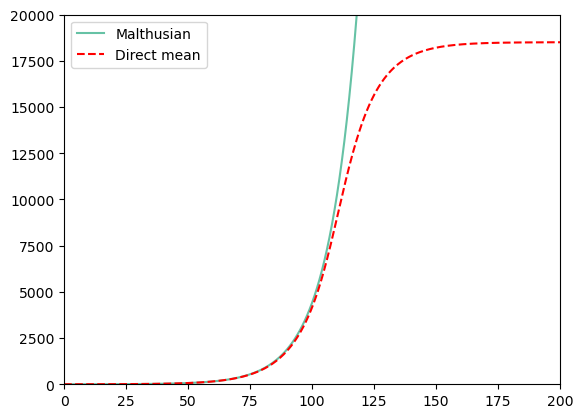

In [11]:
R0_true = sp.integrate.quad(intensity_measure, 0, 100)[0]
print('R0 is: ' + str(R0_true))

def Malthusian_integrand(t, alpha):

    return np.exp(-alpha*t) * lifetime_pdf(t, 0) 

def Malthusian_parameter(alpha):
    return (sp.integrate.quad(Malthusian_integrand, 0, 1000, 
                        args = (alpha))[0] - 1/R0_true)

malpha = sp.optimize.fsolve(Malthusian_parameter, 0.1)
print('malpha is: ' + str(malpha))
showplot = 400



alpha_try = (R0_true**(1/a) - 1)/b
print('Malthusian growth paramater is: ' + str(alpha_try))

malthusian_mean = np.exp(alpha_try*time)
#approximate_mean = np.exp(malpha*time[:showplot])
plt.plot(time, malthusian_mean, label = 'Malthusian')
plt.plot(time, mn_test[:-1], "r--", label = "Direct mean")

plt.xlim([0, 200])
plt.ylim([0, 20000])

plt.legend()

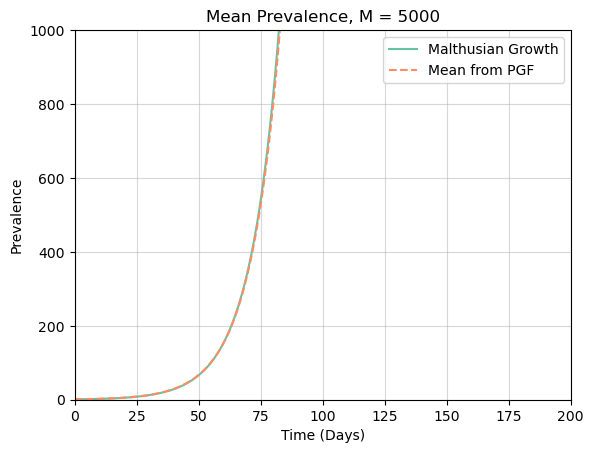

In [12]:
xaxis = (time[1] - time[0]) * np.arange(0, nsteps+1)

showplot = 200

plt.grid(alpha = 0.5)

#plt.plot(xaxis[:showplot], mn_lockdown[:showplot], "g", label = "Lockdown")

#plt.plot(grid[:], (mean_pmf(pmf_immigration))[:], label = "Immigration", color = 'orange')
plt.plot(time, malthusian_mean, label = "Malthusian Growth")
plt.plot(time, mn_test[:-1], '--', label = "Mean from PGF")
#plt.plot(xaxis[:showplot], quick_mn_lockdown[:showplot], "b--", label = "Lockdown mean")

plt.xlabel("Time (Days)")
plt.ylabel("Prevalence")
plt.xlim([0, 200])
plt.ylim([0, 1000])
plt.title("Mean Prevalence, M = 5000")
plt.legend()
#plt.savefig("Mean_Prevalence_M=5000.png")


Text(0, 0.5, 'Probability')

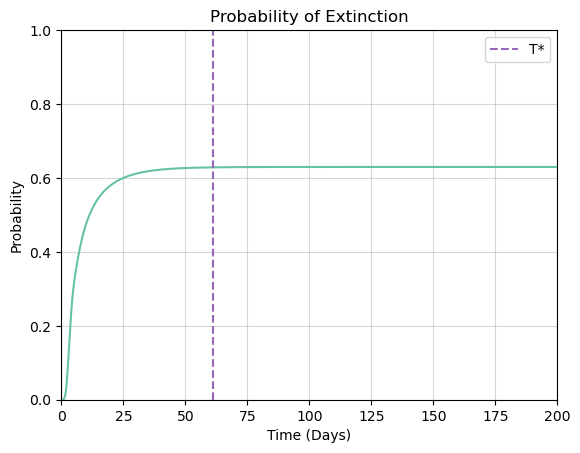

In [13]:
extinction = (cmj_test.extinction_probability(cmj_test.pgf_vec))[:-1]
tstar_idx = np.argwhere(np.gradient(extinction, time_step)<= 0.0001)[1][0]
tstar = time[tstar_idx]
zstar = malthusian_mean[tstar_idx]
plt.grid(alpha = 0.5)
plt.plot(time, (cmj_test.extinction_probability(cmj_test.pgf_vec))[:-1])
plt.axvline(tstar, color = 'tab:purple', linestyle='--', label = "T*")
plt.legend()
plt.xlim([0, 200])
plt.ylim([0, 1])
plt.title("Probability of Extinction")
plt.xlabel("Time (Days)")
plt.ylabel("Probability")
#plt.savefig("p_extinction.png")


In [14]:
Z1 = zstar
Z2 = 1000
T1 = np.argwhere(mn_test >= Z1)[0][0]
T2 = np.argwhere(mn_test >= Z2)[0][0]
tdiff = (T2 - T1)*time_step

Probability sums to 0.9983


Text(0, 0.5, 'Probability')

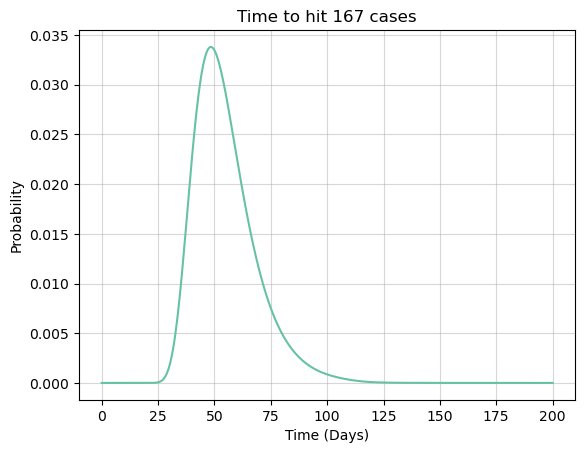

In [15]:

FPT_cdf_small = bp.FirstPassageTime(pmf, Z1, time, False)
FPT_pdf_small = bp.FirstPassageTime(pmf, Z1, time, True)
print('Probability sums to ' + str(np.round(FPT_cdf_small[-1], 4)))
plt.grid(alpha = 0.5)
plt.plot(time, FPT_pdf_small)
plt.title('Time to hit ' + str(int(np.round(Z1))) + ' cases')
plt.xlabel('Time (Days)')
plt.ylabel("Probability")
#plt.savefig("FPT_162.png")

Probability sums to 0.99


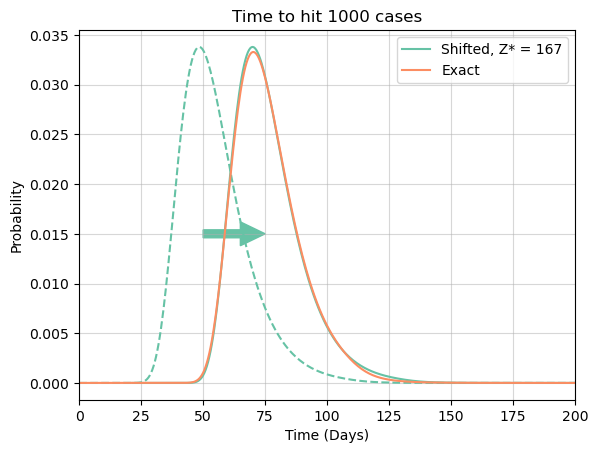

In [16]:

FPT_cdf = bp.FirstPassageTime(pmf, Z2, time, False)
FPT_pdf = bp.FirstPassageTime(pmf, Z2, time, True)
print('Probability sums to ' + str(np.round(FPT_cdf[-1], 4)))


plt.grid(alpha = 0.5)
plt.plot(time, FPT_pdf_small, '--', color = cmap[0])
plt.plot(time +tdiff, FPT_pdf_small, label = 'Shifted, Z* = ' + str(int(zstar)), color = cmap[0])
plt.plot(time, FPT_pdf, label = 'Exact', color = cmap[1])
plt.title('Time to hit ' + str(Z2) + ' cases')
plt.xlabel('Time (Days)')
plt.xlim(0, 200)
plt.arrow(50, 0.015, 25, 0, length_includes_head=True, head_length=10, color = cmap[0], 
         width = 0.0008)
plt.ylabel("Probability")
plt.legend()
#plt.savefig("FPT_" + str(Z2) + "_approx.png")


In [17]:
cfoi = sp.integrate.quad(foi, 0, 100)[0]
print(cfoi)

0.6947905958705475


In [18]:
N = 100000
print('This gets dodgy from I = ' + str(int(np.sqrt(N))))
i0 = 1/N
s0 = (1-i0)
S = np.zeros(nsteps)
I = np.zeros(nsteps)
CI = np.zeros(nsteps)
I[0] = i0
S[0] = 1 - i0
CI[0] = i0
stopping = 500

prev = I
linear = I

integral = np.zeros((nsteps, nsteps))
integral[0, 0] = i0

integral_new = np.zeros((nsteps, nsteps))
#np.fill_diagonal(integral_new, 1/N) 


for n in tqdm(range(1, nsteps)):
    #integral[:(n+1), n] = foi(time[:(n+1)]) * np.flip(I[:(n+1)]) * time_step #* lifetime_pdf(time[:(n+1)], 0) #* cfoi
    
    
    start = lifetime_pdf(time[n], 0)
    new_inc =  start + np.sum(foi(time[:]) * integral_new[:, n])  #lifetime_pdf(time[1:], 0))#* (1-lifetime(time[1:], 0)))
    integral_new += np.diag(new_inc*np.ones_like(np.diag(integral_new, n)), n)
    #print(foi(time[:]) * integral_new[:, n]*N*time_step)
        #integral += (1-S[n-i]) * cfoi * (lifetime_pdf(time[i],
        #            0))* time_step #* infectiousness_pdf(time[0])
        #integral_CI += Rt(time[i]) * infectiousness(time[i]) * lifetime_pdf(time[i], 
        #                                                           0) *CI[n-i]
    

    I[n] =  (S[n-1] * np.sum(integral[:, n])) #+ (1-lifetime(time[n], 0))
    S[n] = S[n-1] - I[n] # np.exp(-integral) * S[0]
    #prev[i] = S[n-1] * np.sum(integral[:, n]) #* lifetime_pdf(time, 0))
    CI[n] = CI[n-1] + I[n]
  

This gets dodgy from I = 316


100%|██████████| 400/400 [00:00<00:00, 3275.92it/s]


In [19]:
#pd.DataFrame(integral_new)
#pd.DataFrame(np.zeros((nsteps, nsteps))+ np.triu(lifetime_pdf(time, 0)).T)
pd.DataFrame(np.triu(np.tile(lifetime_pdf(time, 0), (nsteps, 1)).T))
pd.DataFrame(integral_new)


,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,400
0,0.0,0.000428,0.007509,0.031290,0.072387,0.121503,0.167140,0.201952,0.224679,0.238610,...,1.749539e+06,1.823256e+06,1.900080e+06,1.980140e+06,2.063574e+06,2.150524e+06,2.241137e+06,2.335568e+06,2.433978e+06,2.536534e+06
1,0.0,0.000000,0.000428,0.007509,0.031290,0.072387,0.121503,0.167140,0.201952,0.224679,...,1.678802e+06,1.749539e+06,1.823256e+06,1.900080e+06,1.980140e+06,2.063574e+06,2.150524e+06,2.241137e+06,2.335568e+06,2.433978e+06
2,0.0,0.000000,0.000000,0.000428,0.007509,0.031290,0.072387,0.121503,0.167140,0.201952,...,1.610925e+06,1.678802e+06,1.749539e+06,1.823256e+06,1.900080e+06,1.980140e+06,2.063574e+06,2.150524e+06,2.241137e+06,2.335568e+06
3,0.0,0.000000,0.000000,0.000000,0.000428,0.007509,0.031290,0.072387,0.121503,0.167140,...,1.545793e+06,1.610925e+06,1.678802e+06,1.749539e+06,1.823256e+06,1.900080e+06,1.980140e+06,2.063574e+06,2.150524e+06,2.241137e+06
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000428,0.007509,0.031290,0.072387,0.121503,...,1.483293e+06,1.545793e+06,1.610925e+06,1.678802e+06,1.749539e+06,1.823256e+06,1.900080e+06,1.980140e+06,2.063574e+06,2.150524e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.276789e-04,7.509132e-03,3.128963e-02,7.238728e-02
397,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.276789e-04,7.509132e-03,3.128963e-02
398,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.276789e-04,7.509132e-03
399,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.276789e-04


NameError: name 'integral_sus' is not defined

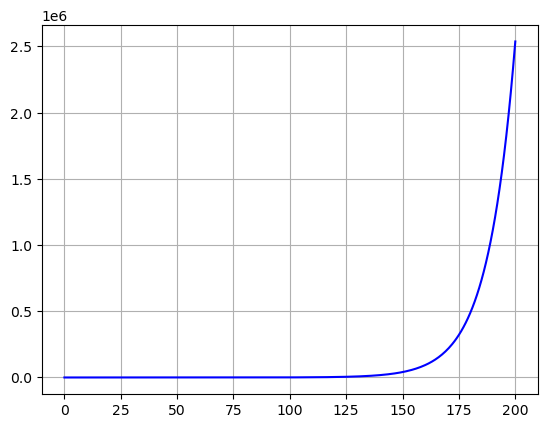

In [20]:
plt.grid()
plt.plot(time, (integral_new)[0, :], 'b', label = 'MVF')
plt.plot(time, (integral_sus)[0, :], 'r', linestyle = 'dashdot', label = 'Sus')
#plt.plot(time, np.gradient(quick_mn_cumulative[:-2], time_step))
plt.legend()
plt.xlim([0, 75])
plt.ylim([0, 600])

In [21]:
N = 100000
print('This gets dodgy from I = ' + str(int(np.sqrt(N))))
i0 = 1/N
s0 = (1-i0)
S = np.zeros(nsteps)
I = np.zeros(nsteps)
CI = np.zeros(nsteps)
I[0] = i0
S[0] = 1 - i0
CI[0] = i0
stopping = 500

prev = I
linear = I

integral = np.zeros((nsteps, nsteps))
integral[0, 0] = i0

integral_sus = np.zeros((nsteps, nsteps))
sus = np.zeros(nsteps)
sus[0] = N*(1-i0)

for n in tqdm(range(1, nsteps)):    
    start = lifetime_pdf(time[n], 0)
    new_inc =  start + (sus[n-1]/N)*np.sum(foi(time[:]) * integral_sus[:, n])  #lifetime_pdf(time[1:], 0))#* (1-lifetime(time[1:], 0)))
    integral_sus += np.diag(new_inc*np.ones_like(np.diag(integral_sus, n)), n)
    sus[n] = sus[n-1] - new_inc

This gets dodgy from I = 316


100%|██████████| 400/400 [00:00<00:00, 3339.09it/s]


(0.0, 10000.0)

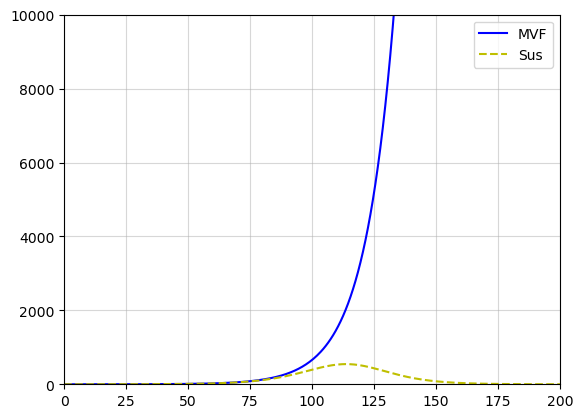

In [22]:
plt.grid(alpha = 0.5)
plt.plot(time, (integral_new)[0, :], 'b', label = 'MVF')
plt.plot(time, (integral_sus)[0, :], 'y--', label = 'Sus')
#plt.plot(time, np.gradient(quick_mn_cumulative[:-1], time_step))
plt.legend()
plt.xlim([0, 200])
plt.ylim([0, 10000])

In [23]:
peak_idx = np.argmax(integral_sus)
time[peak_idx]

113.5

In [24]:
pd.DataFrame(quick_mn)

,0
0,1.000000e+00
1,1.000078e+00
2,1.003000e+00
3,1.020510e+00
4,1.068479e+00
...,...
397,1.415330e+07
398,1.474966e+07
399,1.537114e+07
400,1.601881e+07


In [25]:
borp = np.append(0, np.diff(lifetime(time, 0)))

testing = (((integral_new).T)).dot(lifetime_pdf(time, 0)) + integral_new[0, :]
testing = (((integral_new).T)).dot(lifetime_pdf(time, 0)) + integral_new[0, :]
pd.DataFrame(testing)
#pd.DataFrame(malthusian_mean)


,0
0,0.000000e+00
1,4.276789e-04
2,7.509314e-03
3,3.129605e-02
4,7.247043e-02
...,...
396,5.036515e+06
397,5.248730e+06
398,5.469887e+06
399,5.700363e+06


In [107]:
N = 100000
print('This gets dodgy from I = ' + str(int(np.sqrt(N))))
i0 = 1/N
s0 = (1-i0)
S = np.zeros(nsteps)
I = np.zeros(nsteps)
CI = np.zeros(nsteps)
I[0] = i0
S[0] = 1 - i0
CI[0] = i0
stopping = 500

prev = I
linear = I

integral = np.zeros((nsteps, nsteps))
integral[0, 0] = i0

integral_inc = np.zeros((nsteps, nsteps))
new_prev = np.zeros(nsteps)
new_prev[0] = 1
sus = np.zeros(nsteps)
sus[0] = N*(1-i0)

for n in tqdm(range(1, nsteps)):
    start = (lifetime_pdf(time[n], 0))
    start_prev = 0#(1-lifetime(time[n], 0))
    new_inc =  start + (sus[n-1]/N) *np.sum(foi_t(time[:]) * integral_inc[:, n]) 
    new_prev[n] = start_prev  + np.sum((integral_inc[:, n]) * (1-lifetime(time+time_step, 0)))
    integral_inc += np.diag(new_inc*np.ones_like(np.diag(integral_inc, n)), n)
    
    sus[n] = sus[n-1] - new_inc


This gets dodgy from I = 316


100%|██████████| 400/400 [00:00<00:00, 2781.89it/s]


Text(0, 0.5, 'Prevalence')

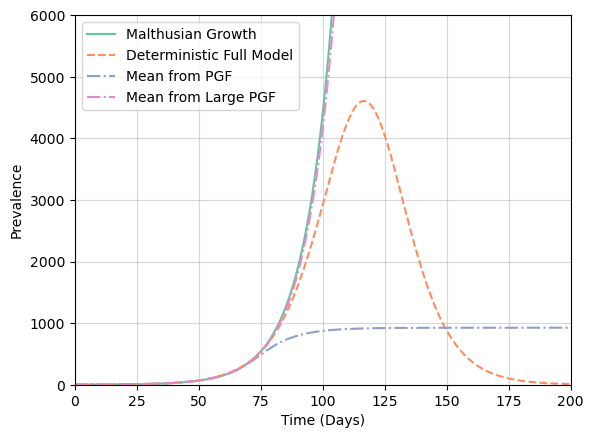

In [52]:
#integral_inc = integral_new.copy()
#integral_inc += np.identity(nsteps)
#for i in range(nsteps):
#    integral_inc[:, i] *= (1-lifetime(time, 0))


plt.grid(alpha = 0.5)
inc = np.sum(integral_inc, axis = 0)
plt.plot(time, malthusian_mean, label = 'Malthusian Growth')
plt.plot(time, new_prev, '--', label = 'Deterministic Full Model')
plt.plot(time, bp.mean_pmf(pmf_test)[:-1], linestyle = 'dashdot', label = 'Mean from PGF')
plt.plot(time, mn_test[:-1], linestyle = 'dashdot', label = 'Mean from Large PGF')
plt.legend(loc = 'upper left')
plt.xlim([0, 200])
plt.ylim([0, 6000])
plt.xlabel("Time (Days)")
plt.ylabel("Prevalence")

#plt.savefig("Deterministic_stochastic.png")

(0.0, 5000.0)

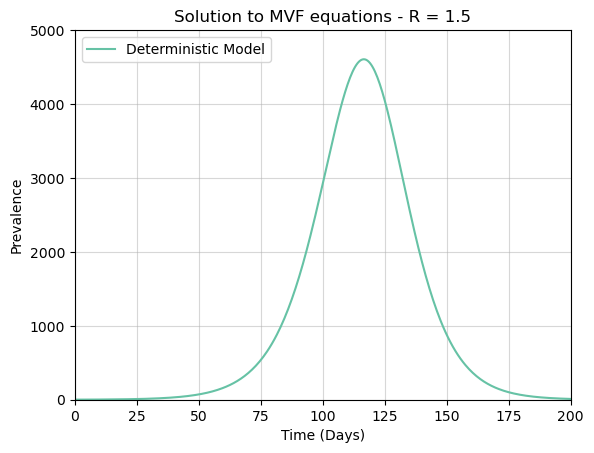

In [53]:

plt.grid(alpha = 0.5)
plt.plot(time, new_prev, label = 'Deterministic Model')
plt.legend(loc = 'upper left')
plt.title("Solution to MVF equations - R = 1.5")
plt.xlabel("Time (Days)")
plt.ylabel("Prevalence")
plt.xlim([0, 200])
plt.ylim([0, 5000])
#plt.savefig("MVF_solution.png")

In [29]:
N = 100000
print('This gets dodgy from I = ' + str(int(np.sqrt(N))))
i0 = 162/N
s0 = (1-i0)
S = np.zeros(nsteps)
I = np.zeros(nsteps)
CI = np.zeros(nsteps)
I[0] = i0
S[0] = 1 - i0
CI[0] = i0
stopping = 500

prev = I
linear = I

integral = np.zeros((nsteps, nsteps))
integral[0, 0] = i0

integral_inc = np.zeros((nsteps, nsteps))
new_prev1 = np.zeros(nsteps)
new_prev1[0] = 162
sus = np.zeros(nsteps)
sus[0] = N*(1-i0)

for n in tqdm(range(1, nsteps)):
    start = (lifetime_pdf(time[n], 0))
    start_prev = (1-lifetime(time[n], 0))
    new_inc =  start + (sus[n-1]/N) *np.sum(foi_t(time[:]) * integral_inc[:, n]) 
    new_prev1[n] = start_prev  + np.sum((integral_inc[:, n]) * (1-lifetime(time+time_step, 0)))
    integral_inc += np.diag(new_inc*np.ones_like(np.diag(integral_inc, n)), n)
    
    sus[n] = sus[n-1] - new_inc

This gets dodgy from I = 316


100%|██████████| 400/400 [00:00<00:00, 2541.23it/s]


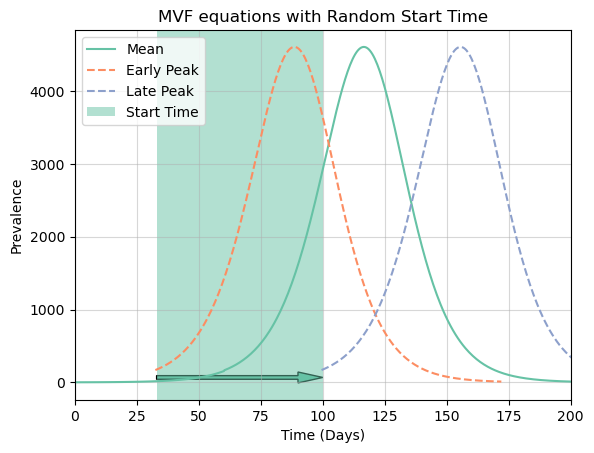

In [69]:
peak = 0

tstar_idx1 = np.argwhere(FPT_cdf_small >= 0.01)[1][0]
timediff1 = time[tstar_idx] - time[tstar_idx1]

tstar_idx2 = np.argwhere(FPT_cdf_small >= 0.99)[1][0]
timediff2 = time[tstar_idx2] - time[tstar_idx]

peak_idx = np.argwhere(new_prev == np.max(new_prev))[0][0]

plt.grid(alpha = 0.5)
#plt.plot(time[:(tstar_idx+1)], malthusian_mean[:(tstar_idx+1)])
plt.plot(time[(tstar_idx-1):], new_prev[(tstar_idx-1):], label = 'Mean')
plt.plot(time[(tstar_idx-1):] - timediff1, new_prev[(tstar_idx-1):], '--', label = 'Early Peak')
plt.plot(time[(tstar_idx-1):] + timediff2, new_prev[(tstar_idx-1):], '--', label = 'Late Peak')
plt.plot(time[:(tstar_idx-1)], malthusian_mean[:(tstar_idx-1)], color = cmap[0])
plt.xlim([0, 200])
plt.xlabel('Time (Days)')
plt.ylabel('Prevalence')

if not peak:
    plt.arrow(time[tstar_idx] - timediff1, zstar - 100, timediff1 + timediff2, 0, 
             width = 50, length_includes_head=True, head_length=10)
    #plt.arrow(time[tstar_idx] + timediff2, (zstar - 100), -(timediff1 + timediff2), 0, 
    #         width = 50, length_includes_head=True, head_length=10)

    plt.axvspan(time[tstar_idx] - timediff1, time[tstar_idx] + timediff2, alpha = 0.5, 
                label = "Start Time")
    plt.title('MVF equations with Random Start Time')
    savename = 'start'
else:
    plt.arrow(time[peak_idx] - timediff1, np.max(new_prev) + 100, timediff1 + timediff2, 0, 
             width = 50, length_includes_head=True, head_length=10, color = cmap[1])
#plt.arrow(time[peak_idx] + timediff2, np.max(new_prev) + 100, -(timediff1 + timediff2), 0, 
#         width = 50, length_includes_head=True, head_length=10)
    plt.axvspan(time[peak_idx] - timediff1, time[peak_idx] + timediff2, alpha = 0.3, 
                color = cmap[1], label = "Peak Time")
    plt.title('Peak Timing Distribution')
    savename = 'peak'

plt.legend()
#plt.savefig("MVF_timedists_" + savename + ".png")

/var/folders/dp/07jgbgpd0wqdpv18kyhd50vr0000gn/T/ipykernel_58735/3878726028.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


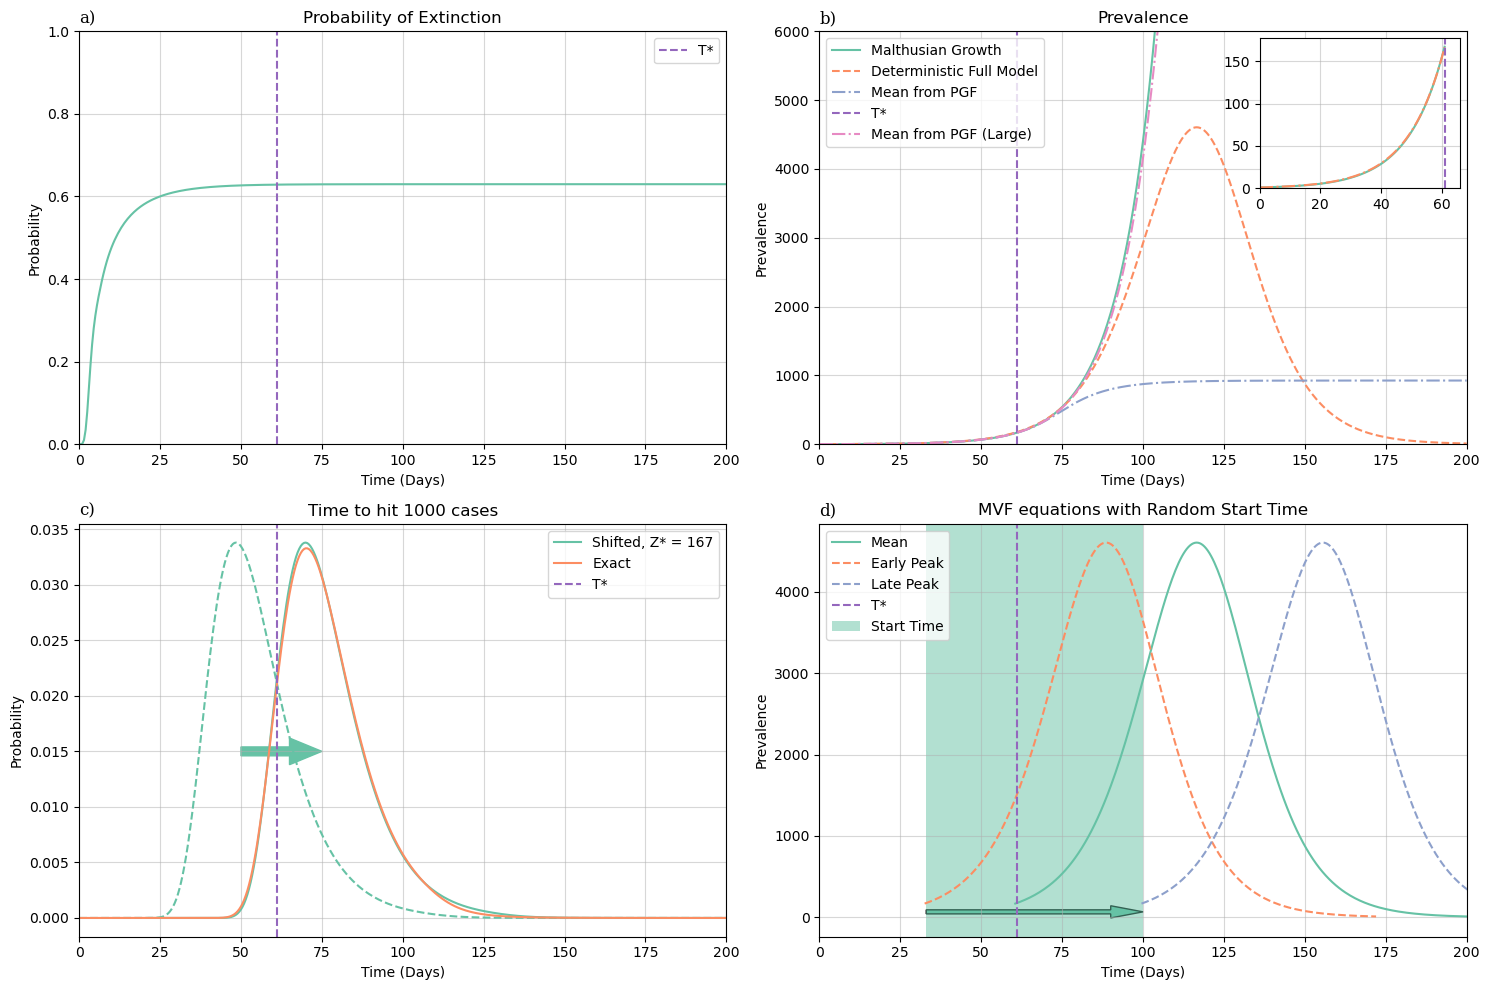

In [130]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, axs = plt.subplots(2, 2, figsize = (15, 10))

### Probability of Extinction / Tstar calculation
axs[0, 0].grid(alpha = 0.5)
axs[0, 0].plot(time, (cmj_test.extinction_probability(cmj_test.pgf_vec))[:-1])
axs[0, 0].axvline(tstar, color = 'tab:purple', linestyle='--', label = "T*")
axs[0, 0].legend()
axs[0, 0].set_xlim([0, 200])
axs[0, 0].set_ylim([0, 1])
axs[0, 0].set_title("Probability of Extinction")
axs[0, 0].set_title('a)', fontfamily='serif', loc='left', fontsize='large')
axs[0, 0].set_xlabel("Time (Days)")
axs[0, 0].set_ylabel("Probability")

### Comparison of results

axs[0, 1].grid(alpha = 0.5)
inc = np.sum(integral_inc, axis = 0)
axs[0, 1].plot(time, malthusian_mean, label = 'Malthusian Growth')
axs[0, 1].plot(time, new_prev, '--', label = 'Deterministic Full Model')
axs[0, 1].plot(time, bp.mean_pmf(pmf_test)[:-1], linestyle = 'dashdot', label = 'Mean from PGF')
axs[0, 1].axvline(tstar, color = 'tab:purple', linestyle='--', label = "T*")
axs[0, 1].plot(time, mn_test[:-1], linestyle = 'dashdot', label = 'Mean from PGF (Large)')
axs[0, 1].legend(loc = 'upper left')
axs[0, 1].set_xlim([0, 200])
axs[0, 1].set_ylim([0, 6000])
axs[0, 1].set_title('Prevalence')
axs[0, 1].set_title('b)', fontfamily='serif', loc='left', fontsize='large')
axs[0, 1].set_xlabel("Time (Days)")
axs[0, 1].set_ylabel("Prevalence")


axins1 = inset_axes(axs[0, 1], 2, 1.5)#, loc=2)
axins1.plot(time[:(tstar_idx+1)],malthusian_mean[:(tstar_idx+1)])
axins1.grid(alpha = 0.5)
#axins1.plot(time[:(tstar_idx+1)],new_prev[:(tstar_idx+1)])
#axins1.plot(time[:(tstar_idx+1)],bp.mean_pmf(pmf_test)[:(tstar_idx+1)])
axins1.plot(time[:(tstar_idx+1)],mn_test[:(tstar_idx+1)], linestyle = 'dashdot')
axins1.axvline(tstar, color = 'tab:purple', linestyle='--')
#axins1.plot(y,datapts.T,'mo')

x1, x2, y1, y2 = 0, tstar + 5, 0, zstar + 10 
axins1.set_xlim(x1, x2)
axins1.set_ylim(y1, y2)

### Validation of First Passage Time

axs[1, 0].grid(alpha = 0.5)
axs[1, 0].plot(time, FPT_pdf_small, '--', color = cmap[0])
axs[1, 0].plot(time +tdiff, FPT_pdf_small, label = 'Shifted, Z* = ' + str(int(zstar)), color = cmap[0])
axs[1, 0].plot(time, FPT_pdf, label = 'Exact', color = cmap[1])
axs[1, 0].axvline(tstar, color = 'tab:purple', linestyle='--', label = "T*")
axs[1, 0].set_title('Time to hit ' + str(Z2) + ' cases')
axs[1, 0].set_title('c)', fontfamily='serif', loc='left', fontsize='large')
axs[1, 0].set_xlabel('Time (Days)')
axs[1, 0].set_xlim(0, 200)
axs[1, 0].arrow(50, 0.015, 25, 0, length_includes_head=True, head_length=10, color = cmap[0], 
         width = 0.0008)
axs[1, 0].set_ylabel("Probability")
axs[1, 0].legend()

### Shift in MVF equations

axs[1, 1].grid(alpha = 0.5)
#plt.plot(time[:(tstar_idx+1)], malthusian_mean[:(tstar_idx+1)])
axs[1, 1].plot(time[(tstar_idx-1):], new_prev[(tstar_idx-1):], label = 'Mean')
axs[1, 1].plot(time[(tstar_idx-1):] - timediff1, new_prev[(tstar_idx-1):], '--', label = 'Early Peak')
axs[1, 1].plot(time[(tstar_idx-1):] + timediff2, new_prev[(tstar_idx-1):], '--', label = 'Late Peak')
axs[1, 1].axvline(tstar, color = 'tab:purple', linestyle='--', label = "T*")
#axs[1, 1].plot(time[:(tstar_idx-1)], malthusian_mean[:(tstar_idx-1)], color = cmap[0])
axs[1, 1].set_xlim([0, 200])
axs[1, 1].set_xlabel('Time (Days)')
axs[1, 1].set_ylabel('Prevalence')

axs[1, 1].arrow(time[tstar_idx] - timediff1, zstar - 100, timediff1 + timediff2, 0, 
            width = 50, length_includes_head=True, head_length=10)


#plt.arrow(time[tstar_idx] + timediff2, (zstar - 100), -(timediff1 + timediff2), 0, 
#         width = 50, length_includes_head=True, head_length=10)

axs[1, 1].axvspan(time[tstar_idx] - timediff1, time[tstar_idx] + timediff2, alpha = 0.5, 
            label = "Start Time")
axs[1, 1].set_title('MVF equations with Random Start Time')
axs[1, 1].set_title('d)', fontfamily='serif', loc='left', fontsize='large')

axs[1, 1].legend()

plt.tight_layout()
plt.savefig('Figures/CMJ_Results_noim.pdf')

In [32]:
def MVF(N, Delta, G, V, rho, pop, BH = False, cumulative = False):
    if cumulative:
        def h(t, tau):
            return 1
    else:
        def h(t, tau):
            return 1 - G(t - tau, tau)
    
    if BH:
        def lam(t, tau):
            return rho(t + tau) * np.gradient(G, Delta)
    else:
        def lam(t, tau):
            return rho(t + tau) * (V(t) - V(t-Delta)) * (1 - G(t, tau))
  
    fhat = np.zeros(shape = (N + 1, N + 1))
    S = np.zeros(N+1)
    S[0] = pop-1
    new_infs = 1
    for n in range(N + 1):
        for i in range(n + 1):
            if i == 0:
                fhat[n, i] = h(n * Delta, n * Delta)
            else:
                sus = (S[i-1])/pop
                new_infs = np.sum(fhat[n, i - np.arange(1, i + 1)]) - new_infs
                fhat[n, i] = h(n * Delta, (n - i) * Delta) + sus * np.sum(fhat[n, i - np.arange(1, i + 1)] * lam(Delta * np.arange(1, i + 1), (n - i) * Delta))
                S[i] = S[i-1] - new_infs
    return np.diagonal(fhat)

quick_MVF = MVF(nsteps, time_step, lifetime, infectiousness, Rt, pop = N)

In [33]:
def mstar_deriv(t):
    return t*np.exp(-malpha*t) * lifetime_pdf(t, 0)

mstar = (R_eff * malpha * sp.integrate.quad(mstar_deriv, 0, 1000))[0]


